# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from metrics import accuracy_fn, cohen_kappa_fn
from models import FlexCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

## 2. Data ETL

In [4]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [5]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

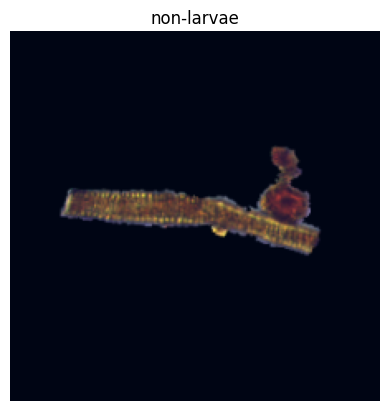

In [6]:
visualize_larvae_sample(train_loader.dataset)

In [7]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(799, 319, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [8]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [9]:
cnn_0 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64],
    conv_channels=[16,32],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Linear-9                   [-1, 64]       6,422,592
             ReLU-10                   [-1, 64]               0
          Dropout-11                   [-1, 64]               0
           Linear-12                    [-1, 2]             130
Total params: 6,427,858
Trainable params: 6,427,858
Non-trainable params: 0
---------------------------

In [ ]:
optimizer_cnn_0 = optim.Adam(cnn_0.parameters(), lr=3e-4)
scheduler_cnn_0 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_0, T_max=50, eta_min=1e-5)
ckpt_cnn_0 = "weights/larvae-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [11]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.7466 | Val Loss: 0.6680 | Train cohen_kappa_fn: 0.1245 | Val cohen_kappa_fn: 0.0954 | Train accuracy_fn: 0.4793 | Val accuracy_fn: 0.4639
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5965 | Val Loss: 0.6071 | Train cohen_kappa_fn: 0.2182 | Val cohen_kappa_fn: 0.0896 | Train accuracy_fn: 0.6108 | Val accuracy_fn: 0.5580
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5606 | Val Loss: 0.6202 | Train cohen_kappa_fn: 0.1505 | Val cohen_kappa_fn: 0.1271 | Train accuracy_fn: 0.4781 | Val accuracy_fn: 0.4828
  ❄️ Performance droped, model won't be saved!


📘 Epoch 4 | Train Loss: 0.5621 | Val Loss: 0.6225 | Train cohen_kappa_fn: 0.2487 | Val cohen_kappa_fn: 0.0867 | Train accuracy_fn: 0.6421 | Val accuracy_fn: 0.6238
  ❄️ Performance droped, model won't be saved!


📘 Epoch 5 | Train Loss: 0.5313 | Val Loss: 0.5903 | Train cohen_kappa_fn: 0.2484 | Val cohen_kappa_fn: 0.0925 | Train accuracy_fn: 0.6471 | Val accuracy_fn: 0.5392
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5098 | Val Loss: 0.5726 | Train cohen_kappa_fn: 0.2881 | Val cohen_kappa_fn: 0.2325 | Train accuracy_fn: 0.7096 | Val accuracy_fn: 0.7335
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5130 | Val Loss: 0.5760 | Train cohen_kappa_fn: 0.2139 | Val cohen_kappa_fn: 0.1568 | Train accuracy_fn: 0.5594 | Val accuracy_fn: 0.5078
  ❄️ Performance droped, model won't be saved!


📘 Epoch 8 | Train Loss: 0.5242 | Val Loss: 0.5627 | Train cohen_kappa_fn: 0.3079 | Val cohen_kappa_fn: 0.1622 | Train accuracy_fn: 0.6821 | Val accuracy_fn: 0.6176
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4906 | Val Loss: 0.5182 | Train cohen_kappa_fn: 0.2818 | Val cohen_kappa_fn: 0.2295 | Train accuracy_fn: 0.6270 | Val accuracy_fn: 0.6019
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4953 | Val Loss: 0.5028 | Train cohen_kappa_fn: 0.3527 | Val cohen_kappa_fn: 0.2506 | Train accuracy_fn: 0.7071 | Val accuracy_fn: 0.6395
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4838 | Val Loss: 0.4895 | Train cohen_kappa_fn: 0.3838 | Val cohen_kappa_fn: 0.3247 | Train accuracy_fn: 0.7735 | Val accuracy_fn: 0.7429
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.4439 | Val Loss: 0.4892 | Train cohen_kappa_fn: 0.4343 | Val cohen_kappa_fn: 0.2750 | Train accuracy_fn: 0.7785 | Val accuracy_fn: 0.6771
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.4285 | Val Loss: 0.4450 | Train cohen_kappa_fn: 0.3871 | Val cohen_kappa_fn: 0.3741 | Train accuracy_fn: 0.7484 | Val accuracy_fn: 0.7618
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.4378 | Val Loss: 0.4597 | Train cohen_kappa_fn: 0.4573 | Val cohen_kappa_fn: 0.4139 | Train accuracy_fn: 0.7972 | Val accuracy_fn: 0.7743
  ❄️ Performance droped, model won't be saved!


📘 Epoch 15 | Train Loss: 0.4067 | Val Loss: 0.4669 | Train cohen_kappa_fn: 0.5533 | Val cohen_kappa_fn: 0.4158 | Train accuracy_fn: 0.8698 | Val accuracy_fn: 0.8558
  ❄️ Performance droped, model won't be saved!


📘 Epoch 16 | Train Loss: 0.4477 | Val Loss: 0.4497 | Train cohen_kappa_fn: 0.4426 | Val cohen_kappa_fn: 0.2995 | Train accuracy_fn: 0.7760 | Val accuracy_fn: 0.6677
  ❄️ Performance droped, model won't be saved!


📘 Epoch 17 | Train Loss: 0.3846 | Val Loss: 0.3858 | Train cohen_kappa_fn: 0.4466 | Val cohen_kappa_fn: 0.4198 | Train accuracy_fn: 0.7710 | Val accuracy_fn: 0.7649
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.4051 | Val Loss: 0.3835 | Train cohen_kappa_fn: 0.4793 | Val cohen_kappa_fn: 0.4982 | Train accuracy_fn: 0.8073 | Val accuracy_fn: 0.8213
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.3751 | Val Loss: 0.4102 | Train cohen_kappa_fn: 0.4280 | Val cohen_kappa_fn: 0.3335 | Train accuracy_fn: 0.7647 | Val accuracy_fn: 0.6928
  ❄️ Performance droped, model won't be saved!


📘 Epoch 20 | Train Loss: 0.3718 | Val Loss: 0.3579 | Train cohen_kappa_fn: 0.5374 | Val cohen_kappa_fn: 0.6398 | Train accuracy_fn: 0.8411 | Val accuracy_fn: 0.8934
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.3796 | Val Loss: 0.3810 | Train cohen_kappa_fn: 0.4629 | Val cohen_kappa_fn: 0.3545 | Train accuracy_fn: 0.7860 | Val accuracy_fn: 0.7053
  ❄️ Performance droped, model won't be saved!


📘 Epoch 22 | Train Loss: 0.3815 | Val Loss: 0.3888 | Train cohen_kappa_fn: 0.5923 | Val cohen_kappa_fn: 0.5886 | Train accuracy_fn: 0.8711 | Val accuracy_fn: 0.8746
  ❄️ Performance droped, model won't be saved!


📘 Epoch 23 | Train Loss: 0.3848 | Val Loss: 0.3909 | Train cohen_kappa_fn: 0.5364 | Val cohen_kappa_fn: 0.3742 | Train accuracy_fn: 0.8335 | Val accuracy_fn: 0.7367
  ❄️ Performance droped, model won't be saved!


📘 Epoch 24 | Train Loss: 0.3716 | Val Loss: 0.3925 | Train cohen_kappa_fn: 0.6003 | Val cohen_kappa_fn: 0.3767 | Train accuracy_fn: 0.8698 | Val accuracy_fn: 0.7335
  ❄️ Performance droped, model won't be saved!


📘 Epoch 25 | Train Loss: 0.3297 | Val Loss: 0.3326 | Train cohen_kappa_fn: 0.6387 | Val cohen_kappa_fn: 0.5394 | Train accuracy_fn: 0.8824 | Val accuracy_fn: 0.8370
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.3521 | Val Loss: 0.3565 | Train cohen_kappa_fn: 0.6274 | Val cohen_kappa_fn: 0.4602 | Train accuracy_fn: 0.8748 | Val accuracy_fn: 0.7837
  ❄️ Performance droped, model won't be saved!


📘 Epoch 27 | Train Loss: 0.3135 | Val Loss: 0.3600 | Train cohen_kappa_fn: 0.5996 | Val cohen_kappa_fn: 0.4108 | Train accuracy_fn: 0.8686 | Val accuracy_fn: 0.7586
  ❄️ Performance droped, model won't be saved!


📘 Epoch 28 | Train Loss: 0.3931 | Val Loss: 0.3525 | Train cohen_kappa_fn: 0.6666 | Val cohen_kappa_fn: 0.5109 | Train accuracy_fn: 0.8949 | Val accuracy_fn: 0.8182
  ❄️ Performance droped, model won't be saved!


📘 Epoch 29 | Train Loss: 0.3227 | Val Loss: 0.3281 | Train cohen_kappa_fn: 0.6250 | Val cohen_kappa_fn: 0.5059 | Train accuracy_fn: 0.8686 | Val accuracy_fn: 0.8119
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.3287 | Val Loss: 0.3272 | Train cohen_kappa_fn: 0.5704 | Val cohen_kappa_fn: 0.4953 | Train accuracy_fn: 0.8498 | Val accuracy_fn: 0.8056
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.3210 | Val Loss: 0.3246 | Train cohen_kappa_fn: 0.7566 | Val cohen_kappa_fn: 0.7670 | Train accuracy_fn: 0.9324 | Val accuracy_fn: 0.9373
  🔥 New best model saved!


📘 Epoch 32 | Train Loss: 0.3187 | Val Loss: 0.3032 | Train cohen_kappa_fn: 0.6919 | Val cohen_kappa_fn: 0.5514 | Train accuracy_fn: 0.9036 | Val accuracy_fn: 0.8433
  🔥 New best model saved!


📘 Epoch 33 | Train Loss: 0.3315 | Val Loss: 0.3248 | Train cohen_kappa_fn: 0.6386 | Val cohen_kappa_fn: 0.4740 | Train accuracy_fn: 0.8798 | Val accuracy_fn: 0.7962
  ❄️ Performance droped, model won't be saved!


📘 Epoch 34 | Train Loss: 0.3119 | Val Loss: 0.3276 | Train cohen_kappa_fn: 0.5945 | Val cohen_kappa_fn: 0.4414 | Train accuracy_fn: 0.8586 | Val accuracy_fn: 0.7712
  ❄️ Performance droped, model won't be saved!


📘 Epoch 35 | Train Loss: 0.2837 | Val Loss: 0.2850 | Train cohen_kappa_fn: 0.7046 | Val cohen_kappa_fn: 0.6528 | Train accuracy_fn: 0.9099 | Val accuracy_fn: 0.8903
  🔥 New best model saved!


📘 Epoch 36 | Train Loss: 0.2814 | Val Loss: 0.3098 | Train cohen_kappa_fn: 0.6508 | Val cohen_kappa_fn: 0.4602 | Train accuracy_fn: 0.8836 | Val accuracy_fn: 0.7837
  ❄️ Performance droped, model won't be saved!


📘 Epoch 37 | Train Loss: 0.2904 | Val Loss: 0.2709 | Train cohen_kappa_fn: 0.7462 | Val cohen_kappa_fn: 0.7418 | Train accuracy_fn: 0.9237 | Val accuracy_fn: 0.9248
  🔥 New best model saved!


📘 Epoch 38 | Train Loss: 0.2763 | Val Loss: 0.2630 | Train cohen_kappa_fn: 0.6781 | Val cohen_kappa_fn: 0.7078 | Train accuracy_fn: 0.8974 | Val accuracy_fn: 0.9122
  🔥 New best model saved!


📘 Epoch 39 | Train Loss: 0.2540 | Val Loss: 0.2613 | Train cohen_kappa_fn: 0.7112 | Val cohen_kappa_fn: 0.7371 | Train accuracy_fn: 0.9111 | Val accuracy_fn: 0.9216
  🔥 New best model saved!


📘 Epoch 40 | Train Loss: 0.2809 | Val Loss: 0.2746 | Train cohen_kappa_fn: 0.7307 | Val cohen_kappa_fn: 0.6430 | Train accuracy_fn: 0.9174 | Val accuracy_fn: 0.8840
  ❄️ Performance droped, model won't be saved!


📘 Epoch 41 | Train Loss: 0.2697 | Val Loss: 0.2890 | Train cohen_kappa_fn: 0.6519 | Val cohen_kappa_fn: 0.5167 | Train accuracy_fn: 0.8849 | Val accuracy_fn: 0.8182
  ❄️ Performance droped, model won't be saved!


📘 Epoch 42 | Train Loss: 0.2719 | Val Loss: 0.2884 | Train cohen_kappa_fn: 0.6775 | Val cohen_kappa_fn: 0.5006 | Train accuracy_fn: 0.8936 | Val accuracy_fn: 0.8088
  ❄️ Performance droped, model won't be saved!


📘 Epoch 43 | Train Loss: 0.2687 | Val Loss: 0.2755 | Train cohen_kappa_fn: 0.7046 | Val cohen_kappa_fn: 0.5765 | Train accuracy_fn: 0.9099 | Val accuracy_fn: 0.8558
  ❄️ Performance droped, model won't be saved!


📘 Epoch 44 | Train Loss: 0.2849 | Val Loss: 0.2708 | Train cohen_kappa_fn: 0.6516 | Val cohen_kappa_fn: 0.5632 | Train accuracy_fn: 0.8824 | Val accuracy_fn: 0.8464
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


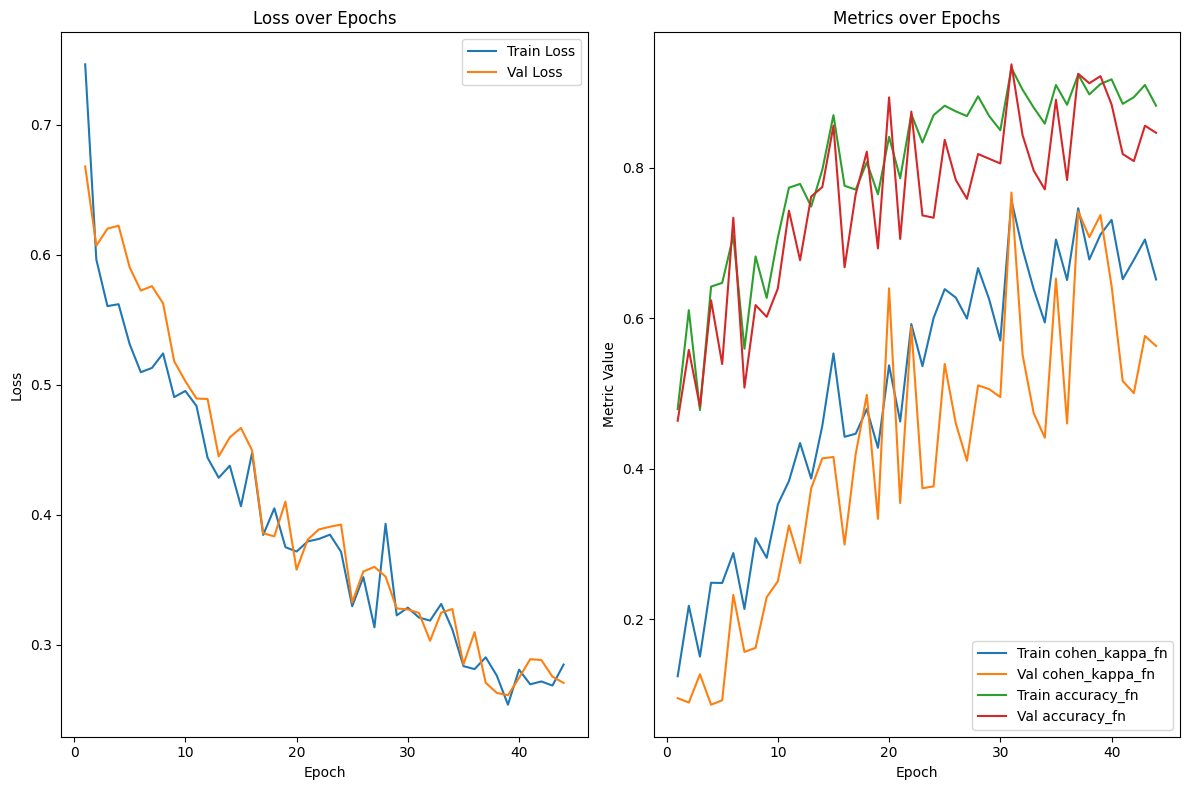

In [12]:
trainer_cnn_0.plot_epochs()

In [ ]:
trainer_cnn_0.test(test_loader)

Test Loss: 0.2996 | Test cohen_kappa_fn: 0.6286 | Test accuracy_fn: 0.8771


### 3.3. CNN1

In [14]:
cnn_1 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64],
    conv_channels=[32,64],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Linear-9                   [-1, 64]      12,845,120
             ReLU-10                   [-1, 64]               0
          Dropout-11                   [-1, 64]               0
           Linear-12                    [-1, 2]             130
Total params: 12,864,738
Trainable params: 12,864,738
Non-trainable params: 0
-------------------------

In [ ]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=3e-4)
scheduler_cnn_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_1, T_max=50, eta_min=1e-5)
ckpt_cnn_1 = "weights/larvae-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [16]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.7338 | Val Loss: 0.5784 | Train cohen_kappa_fn: 0.2152 | Val cohen_kappa_fn: 0.2954 | Train accuracy_fn: 0.6395 | Val accuracy_fn: 0.7962
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5849 | Val Loss: 0.5848 | Train cohen_kappa_fn: 0.2535 | Val cohen_kappa_fn: 0.2171 | Train accuracy_fn: 0.6258 | Val accuracy_fn: 0.6583
  ❄️ Performance droped, model won't be saved!


📘 Epoch 3 | Train Loss: 0.5310 | Val Loss: 0.5861 | Train cohen_kappa_fn: 0.1642 | Val cohen_kappa_fn: 0.1198 | Train accuracy_fn: 0.5044 | Val accuracy_fn: 0.4922
  ❄️ Performance droped, model won't be saved!


📘 Epoch 4 | Train Loss: 0.5356 | Val Loss: 0.5641 | Train cohen_kappa_fn: 0.2179 | Val cohen_kappa_fn: 0.1617 | Train accuracy_fn: 0.5845 | Val accuracy_fn: 0.5799
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5787 | Val Loss: 0.5798 | Train cohen_kappa_fn: 0.1967 | Val cohen_kappa_fn: 0.2053 | Train accuracy_fn: 0.5319 | Val accuracy_fn: 0.5893
  ❄️ Performance droped, model won't be saved!


📘 Epoch 6 | Train Loss: 0.5108 | Val Loss: 0.5842 | Train cohen_kappa_fn: 0.3030 | Val cohen_kappa_fn: 0.1082 | Train accuracy_fn: 0.6984 | Val accuracy_fn: 0.5392
  ❄️ Performance droped, model won't be saved!


📘 Epoch 7 | Train Loss: 0.4925 | Val Loss: 0.5594 | Train cohen_kappa_fn: 0.4657 | Val cohen_kappa_fn: 0.3303 | Train accuracy_fn: 0.8686 | Val accuracy_fn: 0.8840
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5236 | Val Loss: 0.4508 | Train cohen_kappa_fn: 0.3366 | Val cohen_kappa_fn: 0.3807 | Train accuracy_fn: 0.7084 | Val accuracy_fn: 0.7712
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4826 | Val Loss: 0.4680 | Train cohen_kappa_fn: 0.4911 | Val cohen_kappa_fn: 0.6056 | Train accuracy_fn: 0.8461 | Val accuracy_fn: 0.9185
  ❄️ Performance droped, model won't be saved!


📘 Epoch 10 | Train Loss: 0.5117 | Val Loss: 0.4957 | Train cohen_kappa_fn: 0.4518 | Val cohen_kappa_fn: 0.5454 | Train accuracy_fn: 0.8360 | Val accuracy_fn: 0.9091
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.4555 | Val Loss: 0.4639 | Train cohen_kappa_fn: 0.4320 | Val cohen_kappa_fn: 0.4509 | Train accuracy_fn: 0.7897 | Val accuracy_fn: 0.8339
  ❄️ Performance droped, model won't be saved!


📘 Epoch 12 | Train Loss: 0.4481 | Val Loss: 0.4904 | Train cohen_kappa_fn: 0.5353 | Val cohen_kappa_fn: 0.3052 | Train accuracy_fn: 0.8423 | Val accuracy_fn: 0.7712
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.4424 | Val Loss: 0.4706 | Train cohen_kappa_fn: 0.4047 | Val cohen_kappa_fn: 0.2962 | Train accuracy_fn: 0.7572 | Val accuracy_fn: 0.6708
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


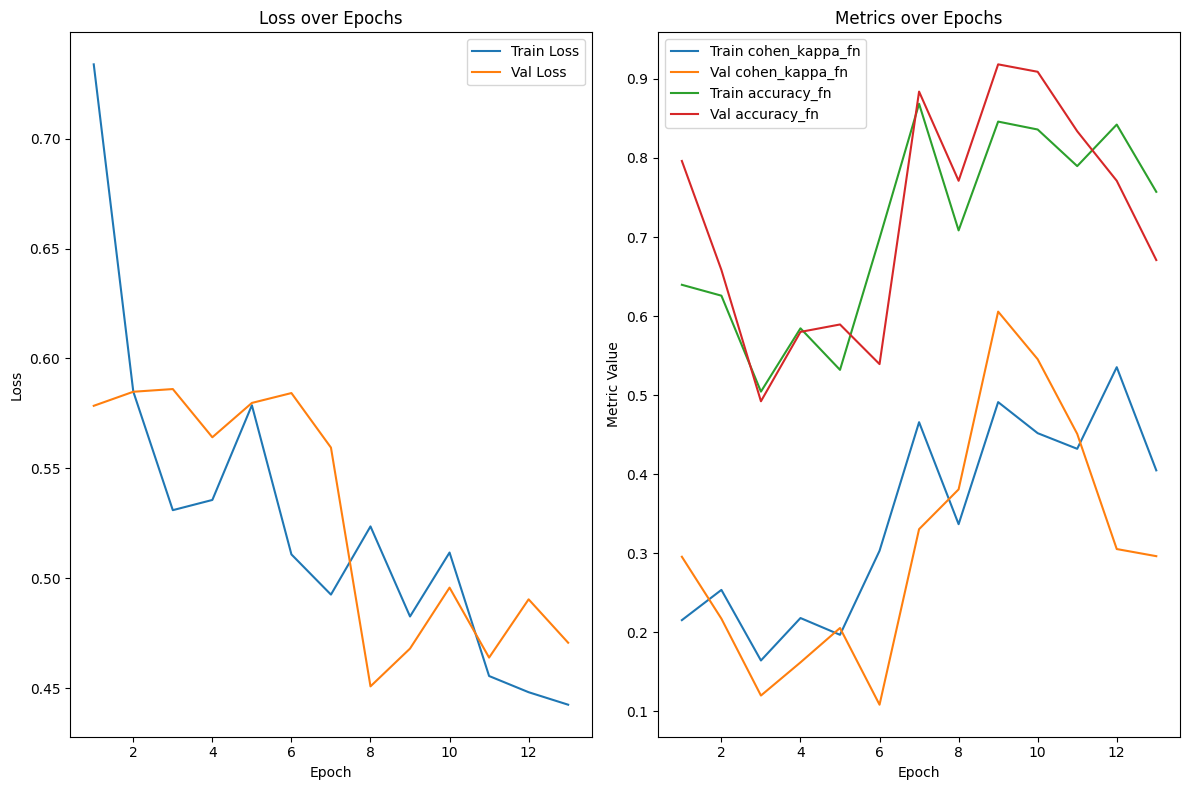

In [17]:
trainer_cnn_1.plot_epochs()

In [ ]:
trainer_cnn_1.test(test_loader)

Test Loss: 0.4711 | Test cohen_kappa_fn: 0.3233 | Test accuracy_fn: 0.7063


### 3.4. CNN2

In [9]:
cnn_2 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,16],
    conv_channels=[8,16,32,64,256],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,432
      BatchNorm2d-14           [-1, 64,

In [10]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=3e-4)
scheduler_cnn_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_2, T_max=50, eta_min=1e-5)
ckpt_cnn_2 = "weights/larvae-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [11]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6934 | Val Loss: 0.6773 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8436 | Val accuracy_fn: 0.8495
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6663 | Val Loss: 0.6285 | Train cohen_kappa_fn: 0.3068 | Val cohen_kappa_fn: 0.2628 | Train accuracy_fn: 0.8123 | Val accuracy_fn: 0.8245
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5908 | Val Loss: 0.5357 | Train cohen_kappa_fn: 0.2599 | Val cohen_kappa_fn: 0.2075 | Train accuracy_fn: 0.6233 | Val accuracy_fn: 0.5925
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4845 | Val Loss: 0.4336 | Train cohen_kappa_fn: 0.2772 | Val cohen_kappa_fn: 0.2935 | Train accuracy_fn: 0.6358 | Val accuracy_fn: 0.6614
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.3700 | Val Loss: 0.3613 | Train cohen_kappa_fn: 0.7582 | Val cohen_kappa_fn: 0.6413 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.9154
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.2746 | Val Loss: 0.2321 | Train cohen_kappa_fn: 0.7429 | Val cohen_kappa_fn: 0.7609 | Train accuracy_fn: 0.9224 | Val accuracy_fn: 0.9342
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2105 | Val Loss: 0.6827 | Train cohen_kappa_fn: 0.6759 | Val cohen_kappa_fn: 0.5267 | Train accuracy_fn: 0.9287 | Val accuracy_fn: 0.9060
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.2126 | Val Loss: 0.9213 | Train cohen_kappa_fn: 0.6272 | Val cohen_kappa_fn: 0.4116 | Train accuracy_fn: 0.9212 | Val accuracy_fn: 0.8934
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.2050 | Val Loss: 0.2202 | Train cohen_kappa_fn: 0.8111 | Val cohen_kappa_fn: 0.7901 | Train accuracy_fn: 0.9449 | Val accuracy_fn: 0.9436
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.1627 | Val Loss: 0.2934 | Train cohen_kappa_fn: 0.8877 | Val cohen_kappa_fn: 0.7782 | Train accuracy_fn: 0.9700 | Val accuracy_fn: 0.9467
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1724 | Val Loss: 0.2996 | Train cohen_kappa_fn: 0.4381 | Val cohen_kappa_fn: 0.4831 | Train accuracy_fn: 0.7584 | Val accuracy_fn: 0.7931
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1808 | Val Loss: 0.3796 | Train cohen_kappa_fn: 0.8320 | Val cohen_kappa_fn: 0.7318 | Train accuracy_fn: 0.9587 | Val accuracy_fn: 0.9373
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1529 | Val Loss: 0.1936 | Train cohen_kappa_fn: 0.8275 | Val cohen_kappa_fn: 0.8103 | Train accuracy_fn: 0.9487 | Val accuracy_fn: 0.9498
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1398 | Val Loss: 0.2584 | Train cohen_kappa_fn: 0.9332 | Val cohen_kappa_fn: 0.8392 | Train accuracy_fn: 0.9825 | Val accuracy_fn: 0.9592
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1439 | Val Loss: 0.2512 | Train cohen_kappa_fn: 0.9064 | Val cohen_kappa_fn: 0.7897 | Train accuracy_fn: 0.9750 | Val accuracy_fn: 0.9467
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1378 | Val Loss: 0.3160 | Train cohen_kappa_fn: 0.9013 | Val cohen_kappa_fn: 0.7630 | Train accuracy_fn: 0.9750 | Val accuracy_fn: 0.9436
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1801 | Val Loss: 0.2437 | Train cohen_kappa_fn: 0.6929 | Val cohen_kappa_fn: 0.6870 | Train accuracy_fn: 0.8986 | Val accuracy_fn: 0.9028
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1277 | Val Loss: 0.1796 | Train cohen_kappa_fn: 0.8713 | Val cohen_kappa_fn: 0.8312 | Train accuracy_fn: 0.9637 | Val accuracy_fn: 0.9561
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1198 | Val Loss: 0.2510 | Train cohen_kappa_fn: 0.9163 | Val cohen_kappa_fn: 0.8312 | Train accuracy_fn: 0.9775 | Val accuracy_fn: 0.9561
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1031 | Val Loss: 0.1820 | Train cohen_kappa_fn: 0.8940 | Val cohen_kappa_fn: 0.8312 | Train accuracy_fn: 0.9712 | Val accuracy_fn: 0.9561
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1224 | Val Loss: 0.1850 | Train cohen_kappa_fn: 0.8255 | Val cohen_kappa_fn: 0.7741 | Train accuracy_fn: 0.9487 | Val accuracy_fn: 0.9373
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1124 | Val Loss: 0.3742 | Train cohen_kappa_fn: 0.8861 | Val cohen_kappa_fn: 0.7540 | Train accuracy_fn: 0.9712 | Val accuracy_fn: 0.9436
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1393 | Val Loss: 0.4986 | Train cohen_kappa_fn: 0.8681 | Val cohen_kappa_fn: 0.7273 | Train accuracy_fn: 0.9675 | Val accuracy_fn: 0.9404
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


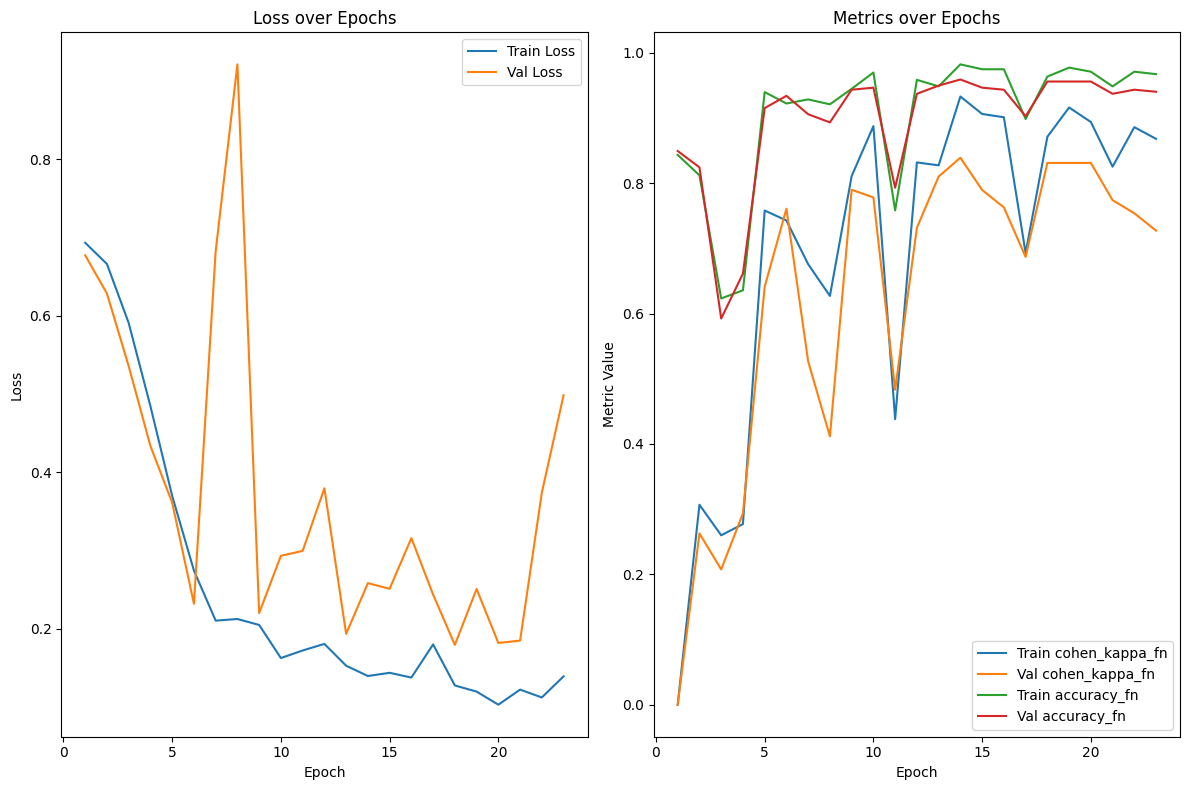

In [12]:
trainer_cnn_2.plot_epochs()

In [13]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2456 | Test cohen_kappa_fn: 0.8132 | Test accuracy_fn: 0.9521


### 3.5. CNN3

In [25]:
cnn_3 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[8,16,32],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Linear-13                  [-1, 128]       3,211,392
             ReLU-14                  [

In [ ]:
optimizer_cnn_3 = optim.Adam(cnn_3.parameters(), lr=3e-4)
scheduler_cnn_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_3, T_max=50, eta_min=1e-5)
ckpt_cnn_3 = "weights/larvae-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [27]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.7457 | Val Loss: 0.6797 | Train cohen_kappa_fn: 0.1935 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8611 | Val accuracy_fn: 0.8558
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6319 | Val Loss: 0.6155 | Train cohen_kappa_fn: 0.2091 | Val cohen_kappa_fn: 0.1002 | Train accuracy_fn: 0.5920 | Val accuracy_fn: 0.5611
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5418 | Val Loss: 0.6516 | Train cohen_kappa_fn: 0.3802 | Val cohen_kappa_fn: 0.0892 | Train accuracy_fn: 0.7822 | Val accuracy_fn: 0.6614
  ❄️ Performance droped, model won't be saved!


📘 Epoch 4 | Train Loss: 0.4859 | Val Loss: 0.5681 | Train cohen_kappa_fn: 0.1990 | Val cohen_kappa_fn: 0.1523 | Train accuracy_fn: 0.5532 | Val accuracy_fn: 0.5204
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5238 | Val Loss: 0.5800 | Train cohen_kappa_fn: 0.3684 | Val cohen_kappa_fn: 0.2123 | Train accuracy_fn: 0.7597 | Val accuracy_fn: 0.7335
  ❄️ Performance droped, model won't be saved!


📘 Epoch 6 | Train Loss: 0.4796 | Val Loss: 0.5544 | Train cohen_kappa_fn: 0.4481 | Val cohen_kappa_fn: 0.2951 | Train accuracy_fn: 0.8160 | Val accuracy_fn: 0.8276
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4741 | Val Loss: 0.5246 | Train cohen_kappa_fn: 0.2600 | Val cohen_kappa_fn: 0.2043 | Train accuracy_fn: 0.6195 | Val accuracy_fn: 0.5799
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4689 | Val Loss: 0.4900 | Train cohen_kappa_fn: 0.2111 | Val cohen_kappa_fn: 0.2063 | Train accuracy_fn: 0.5532 | Val accuracy_fn: 0.5580
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4231 | Val Loss: 0.4851 | Train cohen_kappa_fn: 0.2498 | Val cohen_kappa_fn: 0.2265 | Train accuracy_fn: 0.5982 | Val accuracy_fn: 0.5831
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4319 | Val Loss: 0.4875 | Train cohen_kappa_fn: 0.4476 | Val cohen_kappa_fn: 0.3713 | Train accuracy_fn: 0.7960 | Val accuracy_fn: 0.7649
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.3804 | Val Loss: 0.4292 | Train cohen_kappa_fn: 0.3950 | Val cohen_kappa_fn: 0.3649 | Train accuracy_fn: 0.7522 | Val accuracy_fn: 0.7398
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3701 | Val Loss: 0.4619 | Train cohen_kappa_fn: 0.3789 | Val cohen_kappa_fn: 0.2642 | Train accuracy_fn: 0.7259 | Val accuracy_fn: 0.6395
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.3877 | Val Loss: 0.3675 | Train cohen_kappa_fn: 0.5086 | Val cohen_kappa_fn: 0.4919 | Train accuracy_fn: 0.8210 | Val accuracy_fn: 0.8213
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3624 | Val Loss: 0.3544 | Train cohen_kappa_fn: 0.5753 | Val cohen_kappa_fn: 0.5681 | Train accuracy_fn: 0.8573 | Val accuracy_fn: 0.8683
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3514 | Val Loss: 0.3717 | Train cohen_kappa_fn: 0.5243 | Val cohen_kappa_fn: 0.3868 | Train accuracy_fn: 0.8223 | Val accuracy_fn: 0.7461
  ❄️ Performance droped, model won't be saved!


📘 Epoch 16 | Train Loss: 0.3263 | Val Loss: 0.3643 | Train cohen_kappa_fn: 0.5555 | Val cohen_kappa_fn: 0.4523 | Train accuracy_fn: 0.8423 | Val accuracy_fn: 0.8025
  ❄️ Performance droped, model won't be saved!


📘 Epoch 17 | Train Loss: 0.3065 | Val Loss: 0.3370 | Train cohen_kappa_fn: 0.5410 | Val cohen_kappa_fn: 0.4400 | Train accuracy_fn: 0.8348 | Val accuracy_fn: 0.7868
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2902 | Val Loss: 0.2814 | Train cohen_kappa_fn: 0.5982 | Val cohen_kappa_fn: 0.5862 | Train accuracy_fn: 0.8698 | Val accuracy_fn: 0.8683
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.3014 | Val Loss: 0.3433 | Train cohen_kappa_fn: 0.6754 | Val cohen_kappa_fn: 0.4854 | Train accuracy_fn: 0.9049 | Val accuracy_fn: 0.8213
  ❄️ Performance droped, model won't be saved!


📘 Epoch 20 | Train Loss: 0.3144 | Val Loss: 0.3021 | Train cohen_kappa_fn: 0.6885 | Val cohen_kappa_fn: 0.6092 | Train accuracy_fn: 0.9036 | Val accuracy_fn: 0.8809
  ❄️ Performance droped, model won't be saved!


📘 Epoch 21 | Train Loss: 0.3016 | Val Loss: 0.3295 | Train cohen_kappa_fn: 0.6249 | Val cohen_kappa_fn: 0.4542 | Train accuracy_fn: 0.8711 | Val accuracy_fn: 0.7837
  ❄️ Performance droped, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2658 | Val Loss: 0.2774 | Train cohen_kappa_fn: 0.7111 | Val cohen_kappa_fn: 0.5725 | Train accuracy_fn: 0.9099 | Val accuracy_fn: 0.8621
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2729 | Val Loss: 0.3036 | Train cohen_kappa_fn: 0.6559 | Val cohen_kappa_fn: 0.4887 | Train accuracy_fn: 0.8874 | Val accuracy_fn: 0.8088
  ❄️ Performance droped, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2770 | Val Loss: 0.2968 | Train cohen_kappa_fn: 0.6339 | Val cohen_kappa_fn: 0.5105 | Train accuracy_fn: 0.8761 | Val accuracy_fn: 0.8213
  ❄️ Performance droped, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2598 | Val Loss: 0.3535 | Train cohen_kappa_fn: 0.5740 | Val cohen_kappa_fn: 0.3633 | Train accuracy_fn: 0.8423 | Val accuracy_fn: 0.7179
  ❄️ Performance droped, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2417 | Val Loss: 0.4473 | Train cohen_kappa_fn: 0.5897 | Val cohen_kappa_fn: 0.2931 | Train accuracy_fn: 0.8523 | Val accuracy_fn: 0.6489
  ❄️ Performance droped, model won't be saved!


📘 Epoch 27 | Train Loss: 0.2188 | Val Loss: 0.2600 | Train cohen_kappa_fn: 0.7280 | Val cohen_kappa_fn: 0.5651 | Train accuracy_fn: 0.9186 | Val accuracy_fn: 0.8558
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.2392 | Val Loss: 0.2625 | Train cohen_kappa_fn: 0.7112 | Val cohen_kappa_fn: 0.5919 | Train accuracy_fn: 0.9124 | Val accuracy_fn: 0.8683
  ❄️ Performance droped, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2697 | Val Loss: 0.2918 | Train cohen_kappa_fn: 0.7212 | Val cohen_kappa_fn: 0.5217 | Train accuracy_fn: 0.9161 | Val accuracy_fn: 0.8307
  ❄️ Performance droped, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2420 | Val Loss: 0.2483 | Train cohen_kappa_fn: 0.7274 | Val cohen_kappa_fn: 0.6131 | Train accuracy_fn: 0.9161 | Val accuracy_fn: 0.8777
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.2291 | Val Loss: 0.2689 | Train cohen_kappa_fn: 0.7432 | Val cohen_kappa_fn: 0.5518 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.8464
  ❄️ Performance droped, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2298 | Val Loss: 0.2770 | Train cohen_kappa_fn: 0.7650 | Val cohen_kappa_fn: 0.5576 | Train accuracy_fn: 0.9299 | Val accuracy_fn: 0.8464
  ❄️ Performance droped, model won't be saved!


📘 Epoch 33 | Train Loss: 0.2029 | Val Loss: 0.2496 | Train cohen_kappa_fn: 0.7552 | Val cohen_kappa_fn: 0.6329 | Train accuracy_fn: 0.9274 | Val accuracy_fn: 0.8840
  ❄️ Performance droped, model won't be saved!


📘 Epoch 34 | Train Loss: 0.2256 | Val Loss: 0.2291 | Train cohen_kappa_fn: 0.7158 | Val cohen_kappa_fn: 0.6581 | Train accuracy_fn: 0.9099 | Val accuracy_fn: 0.8966
  🔥 New best model saved!


📘 Epoch 35 | Train Loss: 0.2034 | Val Loss: 0.2581 | Train cohen_kappa_fn: 0.7418 | Val cohen_kappa_fn: 0.5765 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.8558
  ❄️ Performance droped, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1874 | Val Loss: 0.2549 | Train cohen_kappa_fn: 0.7404 | Val cohen_kappa_fn: 0.5830 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.8589
  ❄️ Performance droped, model won't be saved!


📘 Epoch 37 | Train Loss: 0.2189 | Val Loss: 0.2452 | Train cohen_kappa_fn: 0.7866 | Val cohen_kappa_fn: 0.5644 | Train accuracy_fn: 0.9362 | Val accuracy_fn: 0.8527
  ❄️ Performance droped, model won't be saved!


📘 Epoch 38 | Train Loss: 0.2024 | Val Loss: 0.2437 | Train cohen_kappa_fn: 0.7573 | Val cohen_kappa_fn: 0.5907 | Train accuracy_fn: 0.9262 | Val accuracy_fn: 0.8652
  ❄️ Performance droped, model won't be saved!


📘 Epoch 39 | Train Loss: 0.2022 | Val Loss: 0.2595 | Train cohen_kappa_fn: 0.7465 | Val cohen_kappa_fn: 0.5644 | Train accuracy_fn: 0.9212 | Val accuracy_fn: 0.8527
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


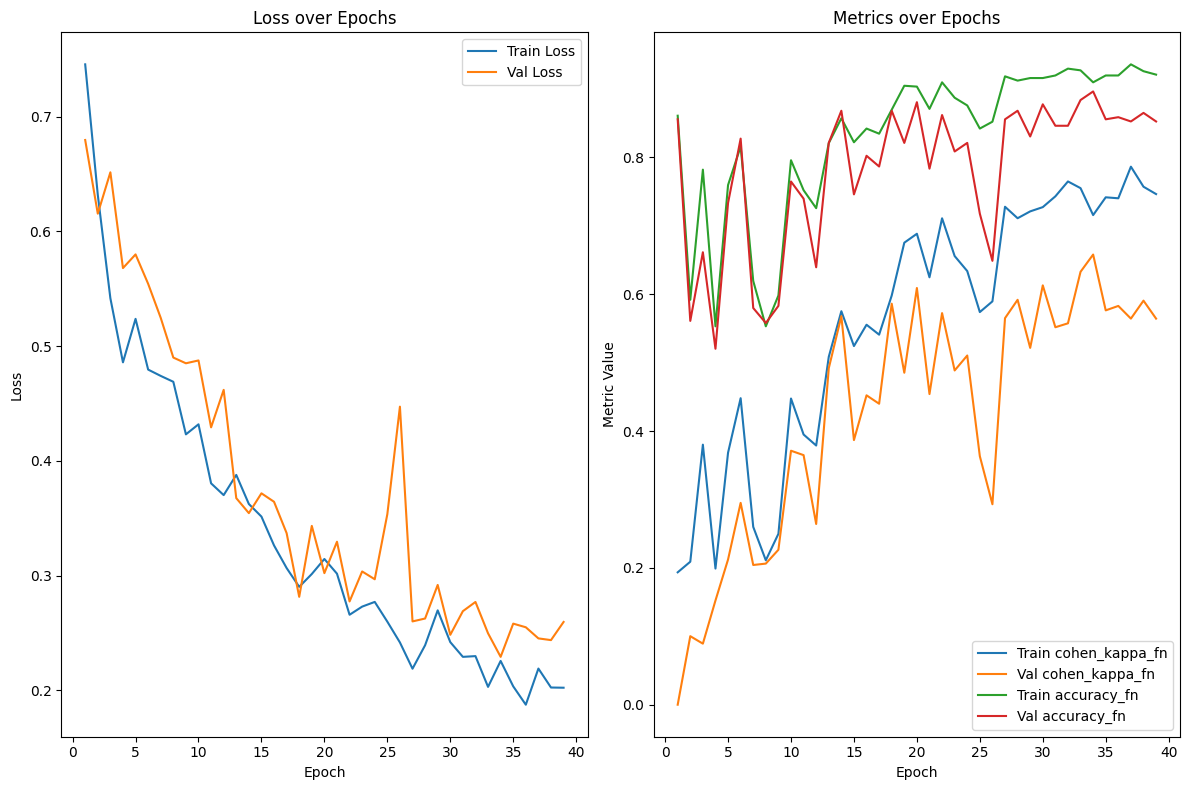

In [28]:
trainer_cnn_3.plot_epochs()

In [ ]:
trainer_cnn_3.test(test_loader)

Test Loss: 0.2485 | Test cohen_kappa_fn: 0.6350 | Test accuracy_fn: 0.8771


### 3.6. CNN4

In [30]:
cnn_4 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64],
    conv_channels=[8,16,32],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_4, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Linear-13                   [-1, 64]       1,605,696
             ReLU-14                   

In [ ]:
optimizer_cnn_4 = optim.Adam(cnn_4.parameters(), lr=3e-4)
scheduler_cnn_4 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_4, T_max=50, eta_min=1e-5)
ckpt_cnn_4 = "weights/larvae-cnn-4.pt"
trainer_cnn_4 = Trainer(
    model=cnn_4,
    optimizer=optimizer_cnn_4,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_4,
    checkpoint_path=ckpt_cnn_4,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [32]:
trainer_cnn_4.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6720 | Val Loss: 0.6870 | Train cohen_kappa_fn: 0.2675 | Val cohen_kappa_fn: -0.0598 | Train accuracy_fn: 0.8010 | Val accuracy_fn: 0.7053
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5836 | Val Loss: 0.6624 | Train cohen_kappa_fn: 0.2963 | Val cohen_kappa_fn: 0.0377 | Train accuracy_fn: 0.7184 | Val accuracy_fn: 0.6552
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5231 | Val Loss: 0.5564 | Train cohen_kappa_fn: 0.1829 | Val cohen_kappa_fn: 0.1924 | Train accuracy_fn: 0.5169 | Val accuracy_fn: 0.5737
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4954 | Val Loss: 0.5396 | Train cohen_kappa_fn: 0.3809 | Val cohen_kappa_fn: 0.3002 | Train accuracy_fn: 0.7422 | Val accuracy_fn: 0.7492
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4507 | Val Loss: 0.5659 | Train cohen_kappa_fn: 0.1793 | Val cohen_kappa_fn: 0.1738 | Train accuracy_fn: 0.5056 | Val accuracy_fn: 0.5141
  ❄️ Performance droped, model won't be saved!


📘 Epoch 6 | Train Loss: 0.3745 | Val Loss: 0.4383 | Train cohen_kappa_fn: 0.5221 | Val cohen_kappa_fn: 0.3550 | Train accuracy_fn: 0.8223 | Val accuracy_fn: 0.7429
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4026 | Val Loss: 0.4869 | Train cohen_kappa_fn: 0.5805 | Val cohen_kappa_fn: 0.4775 | Train accuracy_fn: 0.9011 | Val accuracy_fn: 0.8652
  ❄️ Performance droped, model won't be saved!


📘 Epoch 8 | Train Loss: 0.3598 | Val Loss: 0.4049 | Train cohen_kappa_fn: 0.6039 | Val cohen_kappa_fn: 0.4401 | Train accuracy_fn: 0.8798 | Val accuracy_fn: 0.7994
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3622 | Val Loss: 0.3599 | Train cohen_kappa_fn: 0.6437 | Val cohen_kappa_fn: 0.4565 | Train accuracy_fn: 0.8861 | Val accuracy_fn: 0.7931
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3418 | Val Loss: 0.3530 | Train cohen_kappa_fn: 0.6669 | Val cohen_kappa_fn: 0.4969 | Train accuracy_fn: 0.9024 | Val accuracy_fn: 0.8276
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3379 | Val Loss: 0.3856 | Train cohen_kappa_fn: 0.5330 | Val cohen_kappa_fn: 0.3259 | Train accuracy_fn: 0.8235 | Val accuracy_fn: 0.6803
  ❄️ Performance droped, model won't be saved!


📘 Epoch 12 | Train Loss: 0.3220 | Val Loss: 0.4227 | Train cohen_kappa_fn: 0.4883 | Val cohen_kappa_fn: 0.3259 | Train accuracy_fn: 0.7935 | Val accuracy_fn: 0.6803
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.3353 | Val Loss: 0.3860 | Train cohen_kappa_fn: 0.7349 | Val cohen_kappa_fn: 0.5587 | Train accuracy_fn: 0.9362 | Val accuracy_fn: 0.8871
  ❄️ Performance droped, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2686 | Val Loss: 0.3530 | Train cohen_kappa_fn: 0.6483 | Val cohen_kappa_fn: 0.4233 | Train accuracy_fn: 0.8849 | Val accuracy_fn: 0.7586
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2595 | Val Loss: 0.3144 | Train cohen_kappa_fn: 0.7216 | Val cohen_kappa_fn: 0.4554 | Train accuracy_fn: 0.9186 | Val accuracy_fn: 0.7806
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2581 | Val Loss: 0.2929 | Train cohen_kappa_fn: 0.6512 | Val cohen_kappa_fn: 0.4700 | Train accuracy_fn: 0.8861 | Val accuracy_fn: 0.7900
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2431 | Val Loss: 0.2813 | Train cohen_kappa_fn: 0.6677 | Val cohen_kappa_fn: 0.4799 | Train accuracy_fn: 0.8924 | Val accuracy_fn: 0.7962
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2647 | Val Loss: 0.2967 | Train cohen_kappa_fn: 0.6367 | Val cohen_kappa_fn: 0.4460 | Train accuracy_fn: 0.8773 | Val accuracy_fn: 0.7743
  ❄️ Performance droped, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2534 | Val Loss: 0.3371 | Train cohen_kappa_fn: 0.6127 | Val cohen_kappa_fn: 0.4018 | Train accuracy_fn: 0.8636 | Val accuracy_fn: 0.7429
  ❄️ Performance droped, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2466 | Val Loss: 0.3516 | Train cohen_kappa_fn: 0.5998 | Val cohen_kappa_fn: 0.3775 | Train accuracy_fn: 0.8573 | Val accuracy_fn: 0.7241
  ❄️ Performance droped, model won't be saved!


📘 Epoch 21 | Train Loss: 0.2376 | Val Loss: 0.2349 | Train cohen_kappa_fn: 0.7337 | Val cohen_kappa_fn: 0.6407 | Train accuracy_fn: 0.9224 | Val accuracy_fn: 0.8809
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.2201 | Val Loss: 0.2824 | Train cohen_kappa_fn: 0.6986 | Val cohen_kappa_fn: 0.4460 | Train accuracy_fn: 0.9024 | Val accuracy_fn: 0.7743
  ❄️ Performance droped, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2038 | Val Loss: 0.2934 | Train cohen_kappa_fn: 0.7304 | Val cohen_kappa_fn: 0.4799 | Train accuracy_fn: 0.9161 | Val accuracy_fn: 0.7962
  ❄️ Performance droped, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2275 | Val Loss: 0.2884 | Train cohen_kappa_fn: 0.6909 | Val cohen_kappa_fn: 0.4507 | Train accuracy_fn: 0.8999 | Val accuracy_fn: 0.7774
  ❄️ Performance droped, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2065 | Val Loss: 0.2265 | Train cohen_kappa_fn: 0.7962 | Val cohen_kappa_fn: 0.6288 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.8777
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.1963 | Val Loss: 0.2713 | Train cohen_kappa_fn: 0.6729 | Val cohen_kappa_fn: 0.4953 | Train accuracy_fn: 0.8924 | Val accuracy_fn: 0.8056
  ❄️ Performance droped, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1898 | Val Loss: 0.2857 | Train cohen_kappa_fn: 0.7126 | Val cohen_kappa_fn: 0.4799 | Train accuracy_fn: 0.9086 | Val accuracy_fn: 0.7962
  ❄️ Performance droped, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1872 | Val Loss: 0.2010 | Train cohen_kappa_fn: 0.8613 | Val cohen_kappa_fn: 0.7118 | Train accuracy_fn: 0.9625 | Val accuracy_fn: 0.9154
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.1823 | Val Loss: 0.2093 | Train cohen_kappa_fn: 0.7926 | Val cohen_kappa_fn: 0.6380 | Train accuracy_fn: 0.9412 | Val accuracy_fn: 0.8840
  ❄️ Performance droped, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1873 | Val Loss: 0.3569 | Train cohen_kappa_fn: 0.6495 | Val cohen_kappa_fn: 0.3814 | Train accuracy_fn: 0.8798 | Val accuracy_fn: 0.7273
  ❄️ Performance droped, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1772 | Val Loss: 0.3343 | Train cohen_kappa_fn: 0.7033 | Val cohen_kappa_fn: 0.3935 | Train accuracy_fn: 0.9036 | Val accuracy_fn: 0.7367
  ❄️ Performance droped, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1816 | Val Loss: 0.2522 | Train cohen_kappa_fn: 0.7628 | Val cohen_kappa_fn: 0.5278 | Train accuracy_fn: 0.9287 | Val accuracy_fn: 0.8245
  ❄️ Performance droped, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1839 | Val Loss: 0.2054 | Train cohen_kappa_fn: 0.8169 | Val cohen_kappa_fn: 0.6650 | Train accuracy_fn: 0.9487 | Val accuracy_fn: 0.8934
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


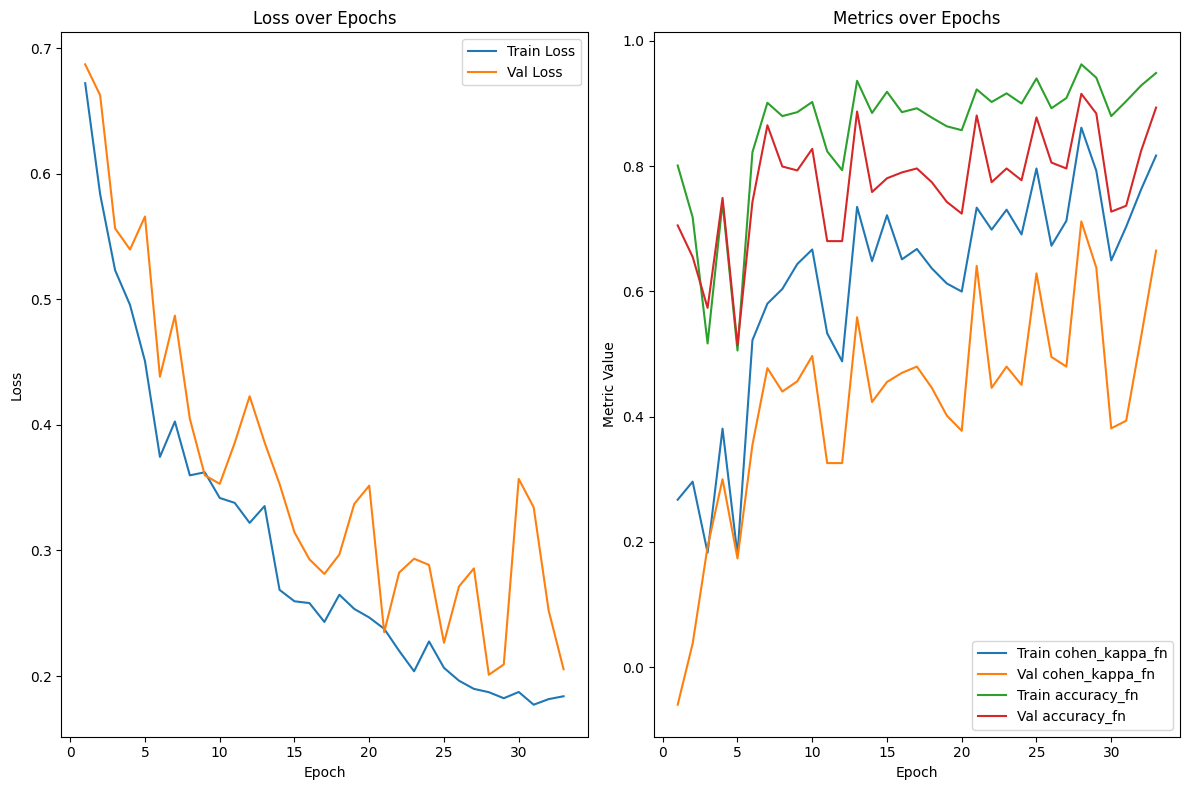

In [33]:
trainer_cnn_4.plot_epochs()

In [ ]:
trainer_cnn_4.test(test_loader)

Test Loss: 0.2429 | Test cohen_kappa_fn: 0.6544 | Test accuracy_fn: 0.8896


### 3.7. CNN5

In [35]:
cnn_5 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64],
    conv_channels=[16,32,64],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_5, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Linear-13                   [-1, 64]       3,211,328
             ReLU-14                   

In [ ]:
optimizer_cnn_5 = optim.Adam(cnn_5.parameters(), lr=3e-4)
scheduler_cnn_5 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_5, T_max=50, eta_min=1e-5)
ckpt_cnn_5 = "weights/larvae-cnn-5.pt"
trainer_cnn_5 = Trainer(
    model=cnn_5,
    optimizer=optimizer_cnn_5,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_5,
    checkpoint_path=ckpt_cnn_5,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [37]:
trainer_cnn_5.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.7485 | Val Loss: 0.6795 | Train cohen_kappa_fn: 0.1493 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8498 | Val accuracy_fn: 0.8558
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5852 | Val Loss: 0.5866 | Train cohen_kappa_fn: 0.3029 | Val cohen_kappa_fn: 0.2599 | Train accuracy_fn: 0.7760 | Val accuracy_fn: 0.8652
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5759 | Val Loss: 0.5348 | Train cohen_kappa_fn: 0.2079 | Val cohen_kappa_fn: 0.2334 | Train accuracy_fn: 0.5670 | Val accuracy_fn: 0.5987
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5017 | Val Loss: 0.4790 | Train cohen_kappa_fn: 0.3122 | Val cohen_kappa_fn: 0.4238 | Train accuracy_fn: 0.7059 | Val accuracy_fn: 0.8025
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4733 | Val Loss: 0.6031 | Train cohen_kappa_fn: 0.1587 | Val cohen_kappa_fn: 0.1287 | Train accuracy_fn: 0.4831 | Val accuracy_fn: 0.4545
  ❄️ Performance droped, model won't be saved!


📘 Epoch 6 | Train Loss: 0.5149 | Val Loss: 0.4830 | Train cohen_kappa_fn: 0.5291 | Val cohen_kappa_fn: 0.4004 | Train accuracy_fn: 0.8523 | Val accuracy_fn: 0.8025
  ❄️ Performance droped, model won't be saved!


📘 Epoch 7 | Train Loss: 0.4403 | Val Loss: 0.3982 | Train cohen_kappa_fn: 0.4301 | Val cohen_kappa_fn: 0.4434 | Train accuracy_fn: 0.7710 | Val accuracy_fn: 0.7931
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4111 | Val Loss: 0.3749 | Train cohen_kappa_fn: 0.3423 | Val cohen_kappa_fn: 0.3751 | Train accuracy_fn: 0.6884 | Val accuracy_fn: 0.7273
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3682 | Val Loss: 0.4577 | Train cohen_kappa_fn: 0.4092 | Val cohen_kappa_fn: 0.2303 | Train accuracy_fn: 0.7534 | Val accuracy_fn: 0.5799
  ❄️ Performance droped, model won't be saved!


📘 Epoch 10 | Train Loss: 0.3388 | Val Loss: 0.3611 | Train cohen_kappa_fn: 0.4921 | Val cohen_kappa_fn: 0.3582 | Train accuracy_fn: 0.7985 | Val accuracy_fn: 0.7085
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3406 | Val Loss: 0.4575 | Train cohen_kappa_fn: 0.2928 | Val cohen_kappa_fn: 0.2408 | Train accuracy_fn: 0.6358 | Val accuracy_fn: 0.5925
  ❄️ Performance droped, model won't be saved!


📘 Epoch 12 | Train Loss: 0.2667 | Val Loss: 0.4193 | Train cohen_kappa_fn: 0.3451 | Val cohen_kappa_fn: 0.2659 | Train accuracy_fn: 0.6846 | Val accuracy_fn: 0.6207
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2891 | Val Loss: 0.4012 | Train cohen_kappa_fn: 0.3996 | Val cohen_kappa_fn: 0.3191 | Train accuracy_fn: 0.7309 | Val accuracy_fn: 0.6740
  ❄️ Performance droped, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2537 | Val Loss: 0.2432 | Train cohen_kappa_fn: 0.6700 | Val cohen_kappa_fn: 0.6150 | Train accuracy_fn: 0.8911 | Val accuracy_fn: 0.8715
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2332 | Val Loss: 0.4064 | Train cohen_kappa_fn: 0.4523 | Val cohen_kappa_fn: 0.2994 | Train accuracy_fn: 0.7672 | Val accuracy_fn: 0.6552
  ❄️ Performance droped, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2276 | Val Loss: 0.3014 | Train cohen_kappa_fn: 0.5669 | Val cohen_kappa_fn: 0.4146 | Train accuracy_fn: 0.8385 | Val accuracy_fn: 0.7524
  ❄️ Performance droped, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2244 | Val Loss: 0.2557 | Train cohen_kappa_fn: 0.6729 | Val cohen_kappa_fn: 0.4901 | Train accuracy_fn: 0.8924 | Val accuracy_fn: 0.8025
  ❄️ Performance droped, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2097 | Val Loss: 0.5385 | Train cohen_kappa_fn: 0.4541 | Val cohen_kappa_fn: 0.2490 | Train accuracy_fn: 0.7685 | Val accuracy_fn: 0.6019
  ❄️ Performance droped, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1917 | Val Loss: 0.1656 | Train cohen_kappa_fn: 0.8558 | Val cohen_kappa_fn: 0.8036 | Train accuracy_fn: 0.9599 | Val accuracy_fn: 0.9467
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2589 | Val Loss: 0.2208 | Train cohen_kappa_fn: 0.6721 | Val cohen_kappa_fn: 0.6133 | Train accuracy_fn: 0.8899 | Val accuracy_fn: 0.8683
  ❄️ Performance droped, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1847 | Val Loss: 0.1883 | Train cohen_kappa_fn: 0.8251 | Val cohen_kappa_fn: 0.7371 | Train accuracy_fn: 0.9499 | Val accuracy_fn: 0.9216
  ❄️ Performance droped, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2225 | Val Loss: 0.3951 | Train cohen_kappa_fn: 0.5281 | Val cohen_kappa_fn: 0.3435 | Train accuracy_fn: 0.8160 | Val accuracy_fn: 0.6959
  ❄️ Performance droped, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1637 | Val Loss: 0.2266 | Train cohen_kappa_fn: 0.6630 | Val cohen_kappa_fn: 0.5507 | Train accuracy_fn: 0.8836 | Val accuracy_fn: 0.8370
  ❄️ Performance droped, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1597 | Val Loss: 0.2007 | Train cohen_kappa_fn: 0.7619 | Val cohen_kappa_fn: 0.6772 | Train accuracy_fn: 0.9249 | Val accuracy_fn: 0.8966
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


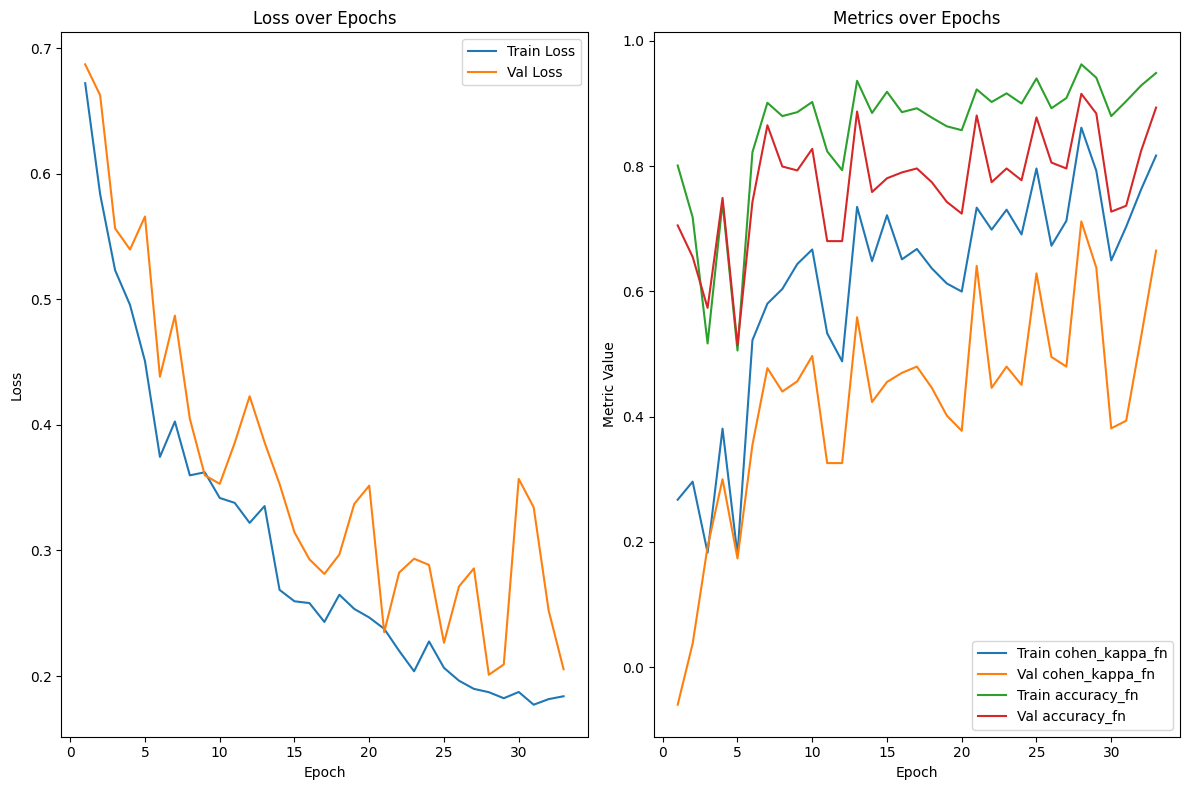

In [ ]:
trainer_cnn_5.plot_epochs()

In [ ]:
trainer_cnn_5.test(test_loader)

Test Loss: 0.2429 | Test cohen_kappa_fn: 0.6544 | Test accuracy_fn: 0.8896


### 3.8. CNN6

In [9]:
cnn_6 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64],
    conv_channels=[8,16,32,64],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_6, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,432
      BatchNorm2d-14           [-1, 64,

In [10]:
optimizer_cnn_6 = optim.Adam(cnn_6.parameters(), lr=3e-4)
scheduler_cnn_6 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_6, T_max=50, eta_min=1e-5)
ckpt_cnn_6 = "weights/larvae-cnn-6.pt"
trainer_cnn_6 = Trainer(
    model=cnn_6,
    optimizer=optimizer_cnn_6,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_6,
    checkpoint_path=ckpt_cnn_6,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [11]:
trainer_cnn_6.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6737 | Val Loss: 0.6910 | Train cohen_kappa_fn: 0.1884 | Val cohen_kappa_fn: -0.0123 | Train accuracy_fn: 0.8486 | Val accuracy_fn: 0.7962
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5920 | Val Loss: 0.5456 | Train cohen_kappa_fn: 0.1532 | Val cohen_kappa_fn: 0.2348 | Train accuracy_fn: 0.4894 | Val accuracy_fn: 0.5862
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5222 | Val Loss: 0.4604 | Train cohen_kappa_fn: 0.2572 | Val cohen_kappa_fn: 0.3431 | Train accuracy_fn: 0.6083 | Val accuracy_fn: 0.6834
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4280 | Val Loss: 0.4587 | Train cohen_kappa_fn: 0.2898 | Val cohen_kappa_fn: 0.2485 | Train accuracy_fn: 0.6471 | Val accuracy_fn: 0.5737
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.3589 | Val Loss: 0.4204 | Train cohen_kappa_fn: 0.3155 | Val cohen_kappa_fn: 0.3131 | Train accuracy_fn: 0.6646 | Val accuracy_fn: 0.6364
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3303 | Val Loss: 0.4015 | Train cohen_kappa_fn: 0.6560 | Val cohen_kappa_fn: 0.5562 | Train accuracy_fn: 0.9011 | Val accuracy_fn: 0.8307
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2926 | Val Loss: 0.3492 | Train cohen_kappa_fn: 0.6110 | Val cohen_kappa_fn: 0.5323 | Train accuracy_fn: 0.8686 | Val accuracy_fn: 0.8056
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2599 | Val Loss: 0.3713 | Train cohen_kappa_fn: 0.7546 | Val cohen_kappa_fn: 0.7429 | Train accuracy_fn: 0.9312 | Val accuracy_fn: 0.9185
  ❄️ Performance droped, model won't be saved!


📘 Epoch 9 | Train Loss: 0.2417 | Val Loss: 0.3189 | Train cohen_kappa_fn: 0.5934 | Val cohen_kappa_fn: 0.6143 | Train accuracy_fn: 0.8573 | Val accuracy_fn: 0.8558
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2401 | Val Loss: 0.3345 | Train cohen_kappa_fn: 0.7166 | Val cohen_kappa_fn: 0.6257 | Train accuracy_fn: 0.9124 | Val accuracy_fn: 0.8558
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1809 | Val Loss: 0.3705 | Train cohen_kappa_fn: 0.7878 | Val cohen_kappa_fn: 0.7715 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.9310
  ❄️ Performance droped, model won't be saved!


📘 Epoch 12 | Train Loss: 0.2157 | Val Loss: 0.3423 | Train cohen_kappa_fn: 0.7891 | Val cohen_kappa_fn: 0.7832 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.9342
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2016 | Val Loss: 0.2944 | Train cohen_kappa_fn: 0.7881 | Val cohen_kappa_fn: 0.7654 | Train accuracy_fn: 0.9374 | Val accuracy_fn: 0.9216
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1578 | Val Loss: 0.3243 | Train cohen_kappa_fn: 0.8221 | Val cohen_kappa_fn: 0.7824 | Train accuracy_fn: 0.9499 | Val accuracy_fn: 0.9310
  ❄️ Performance droped, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1399 | Val Loss: 0.2664 | Train cohen_kappa_fn: 0.7660 | Val cohen_kappa_fn: 0.7984 | Train accuracy_fn: 0.9287 | Val accuracy_fn: 0.9342
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.1643 | Val Loss: 0.4968 | Train cohen_kappa_fn: 0.8333 | Val cohen_kappa_fn: 0.7210 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9216
  ❄️ Performance droped, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1480 | Val Loss: 0.2837 | Train cohen_kappa_fn: 0.8062 | Val cohen_kappa_fn: 0.8132 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9404
  ❄️ Performance droped, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1451 | Val Loss: 0.2922 | Train cohen_kappa_fn: 0.8242 | Val cohen_kappa_fn: 0.8309 | Train accuracy_fn: 0.9499 | Val accuracy_fn: 0.9467
  ❄️ Performance droped, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1266 | Val Loss: 0.2586 | Train cohen_kappa_fn: 0.7149 | Val cohen_kappa_fn: 0.7706 | Train accuracy_fn: 0.9086 | Val accuracy_fn: 0.9216
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.1868 | Val Loss: 0.2689 | Train cohen_kappa_fn: 0.7857 | Val cohen_kappa_fn: 0.8217 | Train accuracy_fn: 0.9362 | Val accuracy_fn: 0.9404
  ❄️ Performance droped, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1903 | Val Loss: 0.4657 | Train cohen_kappa_fn: 0.8559 | Val cohen_kappa_fn: 0.7409 | Train accuracy_fn: 0.9625 | Val accuracy_fn: 0.9248
  ❄️ Performance droped, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1174 | Val Loss: 0.2706 | Train cohen_kappa_fn: 0.7340 | Val cohen_kappa_fn: 0.7233 | Train accuracy_fn: 0.9161 | Val accuracy_fn: 0.8997
  ❄️ Performance droped, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1293 | Val Loss: 0.2632 | Train cohen_kappa_fn: 0.8198 | Val cohen_kappa_fn: 0.8197 | Train accuracy_fn: 0.9474 | Val accuracy_fn: 0.9404
  ❄️ Performance droped, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1066 | Val Loss: 0.4334 | Train cohen_kappa_fn: 0.9078 | Val cohen_kappa_fn: 0.7656 | Train accuracy_fn: 0.9762 | Val accuracy_fn: 0.9310
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


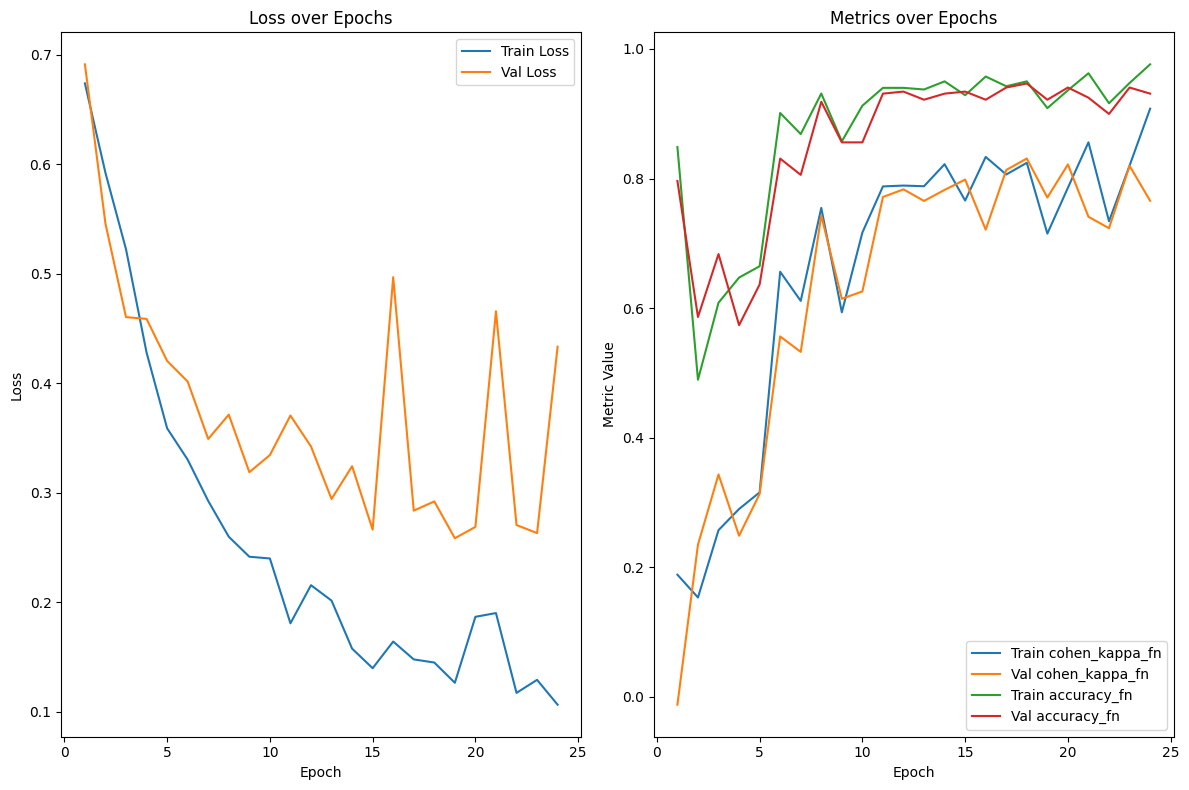

In [12]:
trainer_cnn_6.plot_epochs()

In [13]:
trainer_cnn_6.test(test_loader)

Test Loss: 0.2258 | Test cohen_kappa_fn: 0.7497 | Test accuracy_fn: 0.9375


### 3.9. CNN7

In [32]:
cnn_7 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128,32],
    conv_channels=[8,16,32,64],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_7, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,432
      BatchNorm2d-14           [-1, 64,

In [ ]:
optimizer_cnn_7 = optim.Adam(cnn_7.parameters(), lr=3e-4)
scheduler_cnn_7 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_7, T_max=50, eta_min=1e-5)
ckpt_cnn_7 = "weights/larvae-cnn-7.pt"
trainer_cnn_7 = Trainer(
    model=cnn_7,
    optimizer=optimizer_cnn_7,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_7,
    checkpoint_path=ckpt_cnn_7,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [34]:
trainer_cnn_7.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6845 | Val Loss: 0.6834 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8523 | Val accuracy_fn: 0.8025
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6550 | Val Loss: 0.6060 | Train cohen_kappa_fn: 0.2538 | Val cohen_kappa_fn: 0.3866 | Train accuracy_fn: 0.6483 | Val accuracy_fn: 0.7241
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5743 | Val Loss: 0.5161 | Train cohen_kappa_fn: 0.2693 | Val cohen_kappa_fn: 0.3961 | Train accuracy_fn: 0.6633 | Val accuracy_fn: 0.7273
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5424 | Val Loss: 0.4566 | Train cohen_kappa_fn: 0.3052 | Val cohen_kappa_fn: 0.4424 | Train accuracy_fn: 0.6934 | Val accuracy_fn: 0.7492
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4665 | Val Loss: 0.5081 | Train cohen_kappa_fn: 0.1470 | Val cohen_kappa_fn: 0.2020 | Train accuracy_fn: 0.4656 | Val accuracy_fn: 0.5110
  ❄️ Performance droped, model won't be saved!


📘 Epoch 6 | Train Loss: 0.4124 | Val Loss: 0.3551 | Train cohen_kappa_fn: 0.3370 | Val cohen_kappa_fn: 0.3999 | Train accuracy_fn: 0.6934 | Val accuracy_fn: 0.7085
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4288 | Val Loss: 0.3601 | Train cohen_kappa_fn: 0.4157 | Val cohen_kappa_fn: 0.4606 | Train accuracy_fn: 0.7534 | Val accuracy_fn: 0.7492
  ❄️ Performance droped, model won't be saved!


📘 Epoch 8 | Train Loss: 0.3273 | Val Loss: 0.2944 | Train cohen_kappa_fn: 0.6408 | Val cohen_kappa_fn: 0.7203 | Train accuracy_fn: 0.8849 | Val accuracy_fn: 0.8997
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.2635 | Val Loss: 0.2691 | Train cohen_kappa_fn: 0.6514 | Val cohen_kappa_fn: 0.6549 | Train accuracy_fn: 0.8861 | Val accuracy_fn: 0.8683
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2447 | Val Loss: 0.3056 | Train cohen_kappa_fn: 0.7309 | Val cohen_kappa_fn: 0.7215 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.9091
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.2215 | Val Loss: 0.2215 | Train cohen_kappa_fn: 0.6466 | Val cohen_kappa_fn: 0.6713 | Train accuracy_fn: 0.8849 | Val accuracy_fn: 0.8746
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2214 | Val Loss: 0.2425 | Train cohen_kappa_fn: 0.6200 | Val cohen_kappa_fn: 0.6514 | Train accuracy_fn: 0.8748 | Val accuracy_fn: 0.8683
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2072 | Val Loss: 0.2347 | Train cohen_kappa_fn: 0.7552 | Val cohen_kappa_fn: 0.7760 | Train accuracy_fn: 0.9287 | Val accuracy_fn: 0.9248
  ❄️ Performance droped, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2030 | Val Loss: 0.2976 | Train cohen_kappa_fn: 0.7995 | Val cohen_kappa_fn: 0.7948 | Train accuracy_fn: 0.9437 | Val accuracy_fn: 0.9373
  ❄️ Performance droped, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2102 | Val Loss: 0.1984 | Train cohen_kappa_fn: 0.6999 | Val cohen_kappa_fn: 0.6680 | Train accuracy_fn: 0.9049 | Val accuracy_fn: 0.8715
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.1827 | Val Loss: 0.1864 | Train cohen_kappa_fn: 0.7174 | Val cohen_kappa_fn: 0.7500 | Train accuracy_fn: 0.9136 | Val accuracy_fn: 0.9122
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.1780 | Val Loss: 0.3331 | Train cohen_kappa_fn: 0.8503 | Val cohen_kappa_fn: 0.8317 | Train accuracy_fn: 0.9599 | Val accuracy_fn: 0.9498
  ❄️ Performance droped, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1671 | Val Loss: 0.2069 | Train cohen_kappa_fn: 0.6410 | Val cohen_kappa_fn: 0.6817 | Train accuracy_fn: 0.8798 | Val accuracy_fn: 0.8840
  ❄️ Performance droped, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1434 | Val Loss: 0.3283 | Train cohen_kappa_fn: 0.8390 | Val cohen_kappa_fn: 0.8432 | Train accuracy_fn: 0.9562 | Val accuracy_fn: 0.9530
  ❄️ Performance droped, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1451 | Val Loss: 0.2012 | Train cohen_kappa_fn: 0.6428 | Val cohen_kappa_fn: 0.7305 | Train accuracy_fn: 0.8798 | Val accuracy_fn: 0.9028
  ❄️ Performance droped, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1730 | Val Loss: 0.2393 | Train cohen_kappa_fn: 0.8093 | Val cohen_kappa_fn: 0.8176 | Train accuracy_fn: 0.9449 | Val accuracy_fn: 0.9436
  ❄️ Performance droped, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1346 | Val Loss: 0.2598 | Train cohen_kappa_fn: 0.8234 | Val cohen_kappa_fn: 0.8359 | Train accuracy_fn: 0.9499 | Val accuracy_fn: 0.9498
  ❄️ Performance droped, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1386 | Val Loss: 0.4739 | Train cohen_kappa_fn: 0.8559 | Val cohen_kappa_fn: 0.7908 | Train accuracy_fn: 0.9625 | Val accuracy_fn: 0.9404
  ❄️ Performance droped, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1329 | Val Loss: 0.2607 | Train cohen_kappa_fn: 0.7783 | Val cohen_kappa_fn: 0.8267 | Train accuracy_fn: 0.9362 | Val accuracy_fn: 0.9467
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


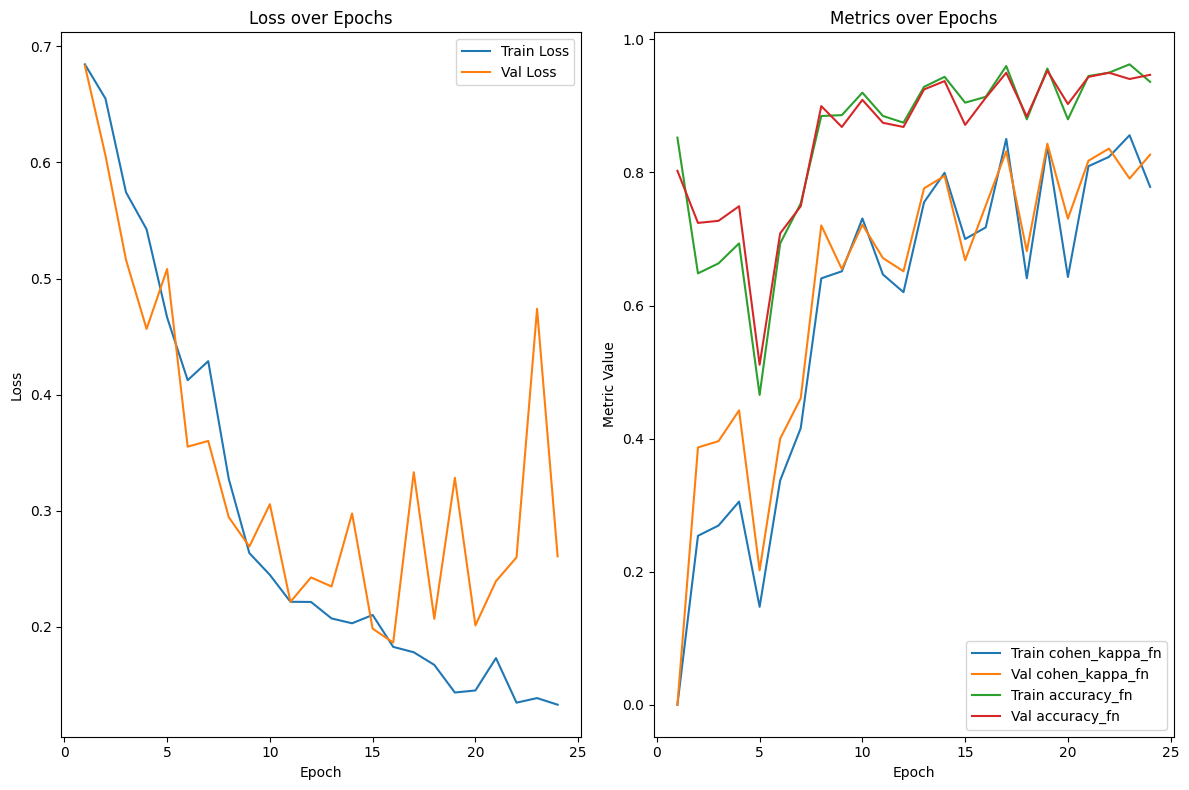

In [35]:
trainer_cnn_7.plot_epochs()

In [ ]:
trainer_cnn_7.test(test_loader)

Test Loss: 0.2656 | Test cohen_kappa_fn: 0.8197 | Test accuracy_fn: 0.9583
